In [1]:
#!pip install psycopg2 если библиотека не установлена
import psycopg2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

user_data = pd.read_sql(
    """SELECT * FROM public.user_data """,
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

user_data.describe()

,user_id,gender,age,exp_group
count,163205.000000,163205.000000,163205.000000,163205.000000
mean,85070.371759,0.551331,27.195405,1.997598
std,48971.639950,0.497360,10.239158,1.413644
min,200.000000,0.000000,14.000000,0.000000
25%,41030.000000,0.000000,19.000000,1.000000
50%,85511.000000,1.000000,24.000000,2.000000
75%,127733.000000,1.000000,33.000000,3.000000
max,168552.000000,1.000000,95.000000,4.000000


In [4]:
post_text = pd.read_sql(
    """SELECT * FROM public.post_text_df """,
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

post_text.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


# Обработка колонки text

In [5]:
# сразу обработаем колонку text, чтоб в дальнейшем уже пользоваться более мощным признаком

In [6]:
# !pip install transformers

In [7]:
### Сделаем эмбеддинги постов с помощью моделей из 10 занятия

from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']

    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }

    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }

    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [8]:
tokenizer, model = get_model('distilbert')

In [9]:
### Сделаем датасет для постов

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])
    
    
dataset = PostDataset(post_text['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

In [10]:
import torch
from tqdm import tqdm


@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = model.to(device)

cuda:0
NVIDIA GeForce RTX 4090


In [12]:
embeddings = get_embeddings_labels(model, loader).numpy()

embeddings

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:17<00:00, 12.46it/s]


array([[ 3.63150716e-01,  4.89373505e-02, -2.64081180e-01, ...,
        -1.41593218e-01,  1.59182400e-02,  9.19411832e-05],
       [ 2.36416489e-01, -1.59501046e-01, -3.27798218e-01, ...,
        -2.89936244e-01,  1.19365521e-01, -1.62345846e-03],
       [ 3.75191540e-01, -1.13943920e-01, -2.40546837e-01, ...,
        -3.38919461e-01,  5.86939044e-02, -2.12657358e-02],
       ...,
       [ 3.40382695e-01,  6.64924458e-02, -1.63184434e-01, ...,
        -8.65627006e-02,  2.03403726e-01,  3.20906155e-02],
       [ 4.32091981e-01,  1.10916672e-02, -1.17306024e-01, ...,
         7.54016489e-02,  1.02739841e-01,  1.52743366e-02],
       [ 3.04277688e-01, -7.62156993e-02, -6.77586794e-02, ...,
        -5.43488823e-02,  2.44383484e-01, -1.41483983e-02]], dtype=float32)

In [13]:
### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = embeddings - embeddings.mean()

pca = PCA(n_components=0.95) # при 0.8 примерно 50 компонент (график ниже для пояснения)
pca_decomp = pca.fit_transform(centered)

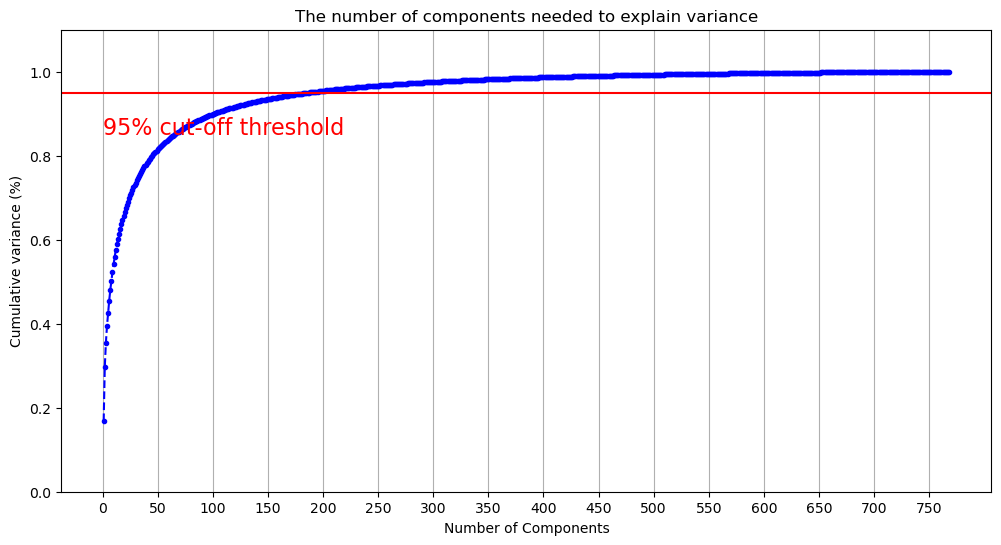

In [14]:
pca_1 = PCA().fit(centered)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 769, step=1)
y = np.cumsum(pca_1.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='.', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 769, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [15]:
from sklearn.cluster import KMeans

In [16]:
def find_best_clusters(df, maximum_K):
    
    clusters_centers = []
    k_values = []
    
    for k in range(1, maximum_K):
        
        kmeans_model = KMeans(n_clusters = k, random_state=0)
        kmeans_model.fit(df)
        
        clusters_centers.append(kmeans_model.inertia_)
        k_values.append(k)
        
    
    return clusters_centers, k_values

In [17]:
def generate_elbow_plot(clusters_centers, k_values):
    
    figure, ax = plt.subplots(figsize = (12, 6))
    plt.plot(k_values, clusters_centers, 'o-', color = 'orange')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of KMeans")
    plt.show()

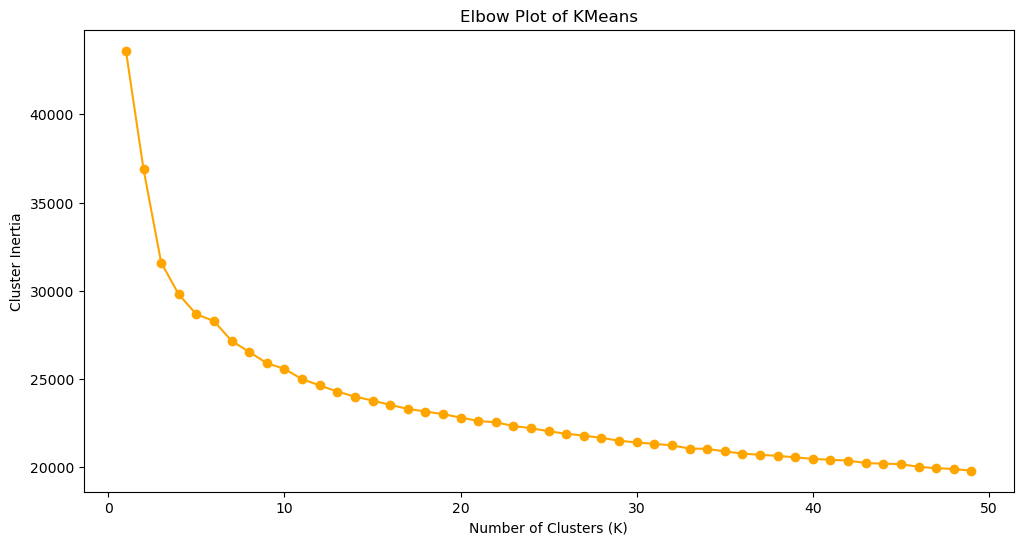

In [18]:
clusters_centers, k_values = find_best_clusters(pca_decomp,50)

generate_elbow_plot(clusters_centers, k_values)

In [19]:
n_clusters = 15

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_decomp)

post_text['TextCluster'] = kmeans.labels_

dists_columns = [f'DistanceToCluster_{i}' for i in range(n_clusters)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14
0,1.865775,3.804101,3.451147,3.676033,3.071969,3.532296,3.463492,2.302598,3.506721,2.427511,3.442934,3.494382,3.502848,3.534554,2.902364
1,1.855902,3.615383,3.464499,3.428530,2.934314,3.321129,3.290498,2.322425,3.390806,2.409006,3.403985,3.399137,3.063769,3.198769,2.647079
2,1.836966,3.657525,3.624265,3.483147,3.155978,3.504563,3.384647,3.132323,3.511461,2.530423,3.383661,3.451279,3.096589,3.222260,3.013088
3,2.572433,3.219802,3.869723,3.936462,3.457973,4.199857,3.819763,3.543765,3.957016,3.001542,3.683072,3.896663,3.871177,3.946612,3.546678
4,2.202173,3.583823,3.138920,3.351208,2.984242,3.515421,3.163522,3.220440,3.136761,2.432492,3.342579,3.152153,3.003548,3.130036,2.552058


In [20]:
post_text = pd.concat((post_text, dists_df), axis=1)

post_text.drop(["text"], axis=1, inplace=True)

post_text

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14
0,1,business,0,1.865775,3.804101,3.451147,3.676033,3.071969,3.532296,3.463492,2.302598,3.506721,2.427511,3.442934,3.494382,3.502848,3.534554,2.902364
1,2,business,0,1.855902,3.615383,3.464499,3.428530,2.934314,3.321129,3.290498,2.322425,3.390806,2.409006,3.403985,3.399137,3.063769,3.198769,2.647079
2,3,business,0,1.836966,3.657525,3.624265,3.483147,3.155978,3.504563,3.384647,3.132323,3.511461,2.530423,3.383661,3.451279,3.096589,3.222260,3.013088
3,4,business,0,2.572433,3.219802,3.869723,3.936462,3.457973,4.199857,3.819763,3.543765,3.957016,3.001542,3.683072,3.896663,3.871177,3.946612,3.546678
4,5,business,0,2.202173,3.583823,3.138920,3.351208,2.984242,3.515421,3.163522,3.220440,3.136761,2.432492,3.342579,3.152153,3.003548,3.130036,2.552058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,movie,11,3.073284,2.533680,1.953563,3.077278,2.922433,3.497069,2.295954,3.440440,1.966307,2.869840,3.242829,1.498300,3.165822,2.050422,2.494059
7019,7316,movie,11,3.043825,2.376036,1.458279,2.713317,2.595701,3.461644,2.012838,3.265992,1.895925,2.575647,3.023644,1.206746,3.285101,1.987502,2.359390
7020,7317,movie,11,3.259399,2.748418,2.108690,2.497564,2.598876,3.528881,2.399741,3.461470,2.086722,2.897748,2.918502,1.591310,3.230717,2.149511,2.551017
7021,7318,movie,8,3.280156,2.174806,1.360149,3.389572,3.176376,3.482358,2.133936,3.504587,1.356962,3.081721,3.506490,1.707576,3.295321,1.821652,2.436318


In [21]:
## Очищаем память чтобы все влезло

model.cpu()

del model
del tokenizer

del dataset
del loader

del embeddings
del centered
del pca
del pca_decomp

In [22]:
import gc

gc.collect()

2868

In [23]:
post_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   post_id               7023 non-null   int64  
 1   topic                 7023 non-null   object 
 2   TextCluster           7023 non-null   int32  
 3   DistanceToCluster_0   7023 non-null   float32
 4   DistanceToCluster_1   7023 non-null   float32
 5   DistanceToCluster_2   7023 non-null   float32
 6   DistanceToCluster_3   7023 non-null   float32
 7   DistanceToCluster_4   7023 non-null   float32
 8   DistanceToCluster_5   7023 non-null   float32
 9   DistanceToCluster_6   7023 non-null   float32
 10  DistanceToCluster_7   7023 non-null   float32
 11  DistanceToCluster_8   7023 non-null   float32
 12  DistanceToCluster_9   7023 non-null   float32
 13  DistanceToCluster_10  7023 non-null   float32
 14  DistanceToCluster_11  7023 non-null   float32
 15  DistanceToCluster_12 

In [24]:
feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 500000""",  # LIMIT 5 000 000
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-17 20:43:46,33796,3264,like,0
1,2021-12-17 20:43:48,33796,6733,view,0
2,2021-12-17 20:46:45,33796,4880,view,0
3,2021-12-17 20:49:15,33796,2610,view,0
4,2021-12-17 20:50:01,33796,4514,view,0


In [25]:
feed_data.describe()

,user_id,post_id,target
count,500000.000000,500000.000000,500000.000000
mean,64582.360942,3393.844030,0.108234
std,44456.670615,2097.589838,0.310676
min,12627.000000,1.000000,0.000000
25%,26205.000000,1521.000000,0.000000
50%,71037.000000,3178.000000,0.000000
75%,84855.000000,5208.000000,0.000000
max,167498.000000,7319.000000,1.000000


In [26]:
df = pd.merge(
    user_data,
    feed_data,
    on='user_id',
    how='outer'
) 

In [27]:
df = pd.merge(
    df,
    post_text,
    on='post_id',
    how='outer'
)

In [28]:
df

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14
0,200.0,1.0,34.0,Russia,Degtyarsk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201.0,0.0,37.0,Russia,Abakan,0.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202.0,1.0,17.0,Russia,Smolensk,4.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,203.0,0.0,18.0,Russia,Moscow,1.0,iOS,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204.0,0.0,36.0,Russia,Anzhero-Sudzhensk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,3998.0,...,4.107583,3.753114,3.838913,3.652239,3.382991,2.365867,3.550978,3.707293,3.654159,3.599118
662330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4089.0,...,4.202417,3.673074,3.993683,3.635429,3.560068,2.934697,3.453243,3.748631,3.733140,3.440623
662331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4099.0,...,3.541975,3.382361,3.170268,3.209351,2.641374,1.987588,2.929799,3.334634,3.208457,3.042331
662332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4118.0,...,3.739968,3.592566,3.910847,3.316971,3.391457,2.923803,3.034843,3.414204,3.304018,3.369232


In [29]:
### Избавимся от записей о лайках, поставленных после просмотра поста

df[df['target']==1]

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14
162148,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,2021-11-17 21:41:23,5515.0,...,3.438293,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354
162150,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,2021-12-09 14:52:25,5515.0,...,3.438293,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354
162165,20163.0,1.0,21.0,Ukraine,Vinnytsia,0.0,Android,ads,2021-12-06 07:04:17,5515.0,...,3.438293,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354
162184,39742.0,0.0,15.0,Finland,Helsinki,4.0,Android,ads,2021-11-12 21:52:07,5515.0,...,3.438293,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354
162195,39802.0,1.0,19.0,Russia,Moscow,1.0,iOS,ads,2021-12-23 18:47:50,5515.0,...,3.438293,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662083,71050.0,1.0,47.0,Russia,Lobnya,3.0,iOS,ads,2021-12-13 15:21:22,3716.0,...,4.011280,3.657462,3.844534,3.579417,3.299514,2.102684,3.438984,3.655536,3.552599,3.452173
662086,71090.0,1.0,15.0,Russia,Novaya Balakhna,1.0,iOS,ads,2021-10-03 16:55:04,3716.0,...,4.011280,3.657462,3.844534,3.579417,3.299514,2.102684,3.438984,3.655536,3.552599,3.452173
662110,167456.0,1.0,41.0,Russia,Novyy Sharoy,1.0,Android,organic,2021-10-18 21:03:44,3716.0,...,4.011280,3.657462,3.844534,3.579417,3.299514,2.102684,3.438984,3.655536,3.552599,3.452173
662116,33805.0,1.0,23.0,Russia,Nizhniy Novgorod,1.0,Android,ads,2021-10-18 13:26:59,3735.0,...,3.806628,3.386125,3.707334,3.323118,2.968395,1.562201,3.078778,3.363069,3.308071,3.141157


In [30]:
#Создаём новую переменную, которая и будет целевой(таргет). 
#Все записи, где был лайк(неважно сразу после просмотра или нет) определяем как 1, в противном случае как 0.

df['target_predict'] = 0
df.loc[(df['target']==1),'target_predict'] = 1
df.loc[(df['action']=='like'),'target_predict'] = 1
df

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict
0,200.0,1.0,34.0,Russia,Degtyarsk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,201.0,0.0,37.0,Russia,Abakan,0.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,202.0,1.0,17.0,Russia,Smolensk,4.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,203.0,0.0,18.0,Russia,Moscow,1.0,iOS,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,204.0,0.0,36.0,Russia,Anzhero-Sudzhensk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,3998.0,...,3.753114,3.838913,3.652239,3.382991,2.365867,3.550978,3.707293,3.654159,3.599118,0
662330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4089.0,...,3.673074,3.993683,3.635429,3.560068,2.934697,3.453243,3.748631,3.733140,3.440623,0
662331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4099.0,...,3.382361,3.170268,3.209351,2.641374,1.987588,2.929799,3.334634,3.208457,3.042331,0
662332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4118.0,...,3.592566,3.910847,3.316971,3.391457,2.923803,3.034843,3.414204,3.304018,3.369232,0


In [31]:
df[df['target_predict']==1]

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict
162148,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,2021-11-17 21:41:23,5515.0,...,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1
162149,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,2021-11-17 21:42:17,5515.0,...,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1
162150,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,2021-12-09 14:52:25,5515.0,...,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1
162151,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,2021-12-09 14:53:52,5515.0,...,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1
162165,20163.0,1.0,21.0,Ukraine,Vinnytsia,0.0,Android,ads,2021-12-06 07:04:17,5515.0,...,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662111,167456.0,1.0,41.0,Russia,Novyy Sharoy,1.0,Android,organic,2021-10-18 21:04:51,3716.0,...,3.657462,3.844534,3.579417,3.299514,2.102684,3.438984,3.655536,3.552599,3.452173,1
662116,33805.0,1.0,23.0,Russia,Nizhniy Novgorod,1.0,Android,ads,2021-10-18 13:26:59,3735.0,...,3.386125,3.707334,3.323118,2.968395,1.562201,3.078778,3.363069,3.308071,3.141157,1
662117,33805.0,1.0,23.0,Russia,Nizhniy Novgorod,1.0,Android,ads,2021-10-18 13:27:13,3735.0,...,3.386125,3.707334,3.323118,2.968395,1.562201,3.078778,3.363069,3.308071,3.141157,1
662122,39854.0,1.0,37.0,Russia,Saint Petersburg,4.0,Android,ads,2021-11-05 21:13:07,3735.0,...,3.386125,3.707334,3.323118,2.968395,1.562201,3.078778,3.363069,3.308071,3.141157,1


In [32]:
df = df.drop(['action', 'target'], axis=1)
df

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict
0,200.0,1.0,34.0,Russia,Degtyarsk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,201.0,0.0,37.0,Russia,Abakan,0.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,202.0,1.0,17.0,Russia,Smolensk,4.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,203.0,0.0,18.0,Russia,Moscow,1.0,iOS,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,204.0,0.0,36.0,Russia,Anzhero-Sudzhensk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,3998.0,...,3.753114,3.838913,3.652239,3.382991,2.365867,3.550978,3.707293,3.654159,3.599118,0
662330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4089.0,...,3.673074,3.993683,3.635429,3.560068,2.934697,3.453243,3.748631,3.733140,3.440623,0
662331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4099.0,...,3.382361,3.170268,3.209351,2.641374,1.987588,2.929799,3.334634,3.208457,3.042331,0
662332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4118.0,...,3.592566,3.910847,3.316971,3.391457,2.923803,3.034843,3.414204,3.304018,3.369232,0


In [33]:
df.info()
# видим, что только в колонках post_id, timestamp,(TextCluster, DistanceToCluster_xx), topic пропущенные значения
# предлагаю проверить сколько пропущенных значений в этих колонках при df['target_predict']==1, 
# т.к. количесвто записей с таргетной перемненной равной 1 гораздо меньше чем кол-во записей == 0, 
# поэтому может быть избавление от записей будет некритичино

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662334 entries, 0 to 662333
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               662142 non-null  float64       
 1   gender                662142 non-null  float64       
 2   age                   662142 non-null  float64       
 3   country               662142 non-null  object        
 4   city                  662142 non-null  object        
 5   exp_group             662142 non-null  float64       
 6   os                    662142 non-null  object        
 7   source                662142 non-null  object        
 8   timestamp             500000 non-null  datetime64[ns]
 9   post_id               500192 non-null  float64       
 10  topic                 500192 non-null  object        
 11  TextCluster           500192 non-null  float64       
 12  DistanceToCluster_0   500192 non-null  float32       
 13 

In [34]:
df[df['target_predict']==1].info()
# все пропуски в других записях, поэтому убрать их будет некритично, однако сделаем это позже 
# - после отправки на удалённый сервер обработанных таблиц user_id и post_id

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108235 entries, 162148 to 662123
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               108235 non-null  float64       
 1   gender                108235 non-null  float64       
 2   age                   108235 non-null  float64       
 3   country               108235 non-null  object        
 4   city                  108235 non-null  object        
 5   exp_group             108235 non-null  float64       
 6   os                    108235 non-null  object        
 7   source                108235 non-null  object        
 8   timestamp             108235 non-null  datetime64[ns]
 9   post_id               108235 non-null  float64       
 10  topic                 108235 non-null  object        
 11  TextCluster           108235 non-null  float64       
 12  DistanceToCluster_0   108235 non-null  float32       

In [35]:
# df.dropna(inplace=True)
# df.info()

# Обработка временных данных (timestamp)

In [36]:
# посмотрим на временные данные
df[df['timestamp'].notna() == True].sort_values('timestamp')
# промежуток для изучения  - чуть меньше трёх месяцев. 
# Поэтому думаю, что имеет смысл попробовать закодировать только день и час.

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict
446384,84869.0,1.0,23.0,Russia,Gorodets,2.0,iOS,ads,2021-10-01 06:05:25,6826.0,...,2.055129,3.182888,1.885181,2.717182,3.188869,2.095850,3.419935,2.298622,2.432139,0
330196,39815.0,1.0,14.0,Russia,Toguchin,3.0,Android,ads,2021-10-01 06:07:11,1154.0,...,3.546648,1.589758,3.560331,2.796167,3.928711,3.473752,3.363699,3.335275,2.909281,1
627695,26198.0,1.0,48.0,Russia,Melensk,0.0,Android,ads,2021-10-01 06:07:11,5197.0,...,1.879601,3.532537,1.880390,2.743324,3.329661,1.662927,3.473580,2.196869,2.488292,1
468574,84869.0,1.0,23.0,Russia,Gorodets,2.0,iOS,ads,2021-10-01 06:07:31,988.0,...,3.401111,1.522295,3.273706,2.907342,3.888155,3.287415,3.407893,3.051739,2.781165,1
330197,39815.0,1.0,14.0,Russia,Toguchin,3.0,Android,ads,2021-10-01 06:09:21,1154.0,...,3.546648,1.589758,3.560331,2.796167,3.928711,3.473752,3.363699,3.335275,2.909281,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210669,20156.0,0.0,16.0,Russia,Asino,4.0,Android,ads,2021-12-29 23:43:55,5845.0,...,2.344370,3.162237,2.174551,2.593030,3.166176,2.223267,3.009679,1.818818,2.482280,0
321499,20156.0,0.0,16.0,Russia,Asino,4.0,Android,ads,2021-12-29 23:45:27,5575.0,...,1.786662,3.504216,1.395203,2.933079,3.401796,1.776749,3.422787,1.918388,2.352786,0
548239,106184.0,1.0,39.0,Russia,Moscow,3.0,iOS,ads,2021-12-29 23:46:10,1381.0,...,3.614427,3.087789,3.352548,3.465481,4.003582,3.380972,2.755004,3.196198,3.040084,1
565139,20156.0,0.0,16.0,Russia,Asino,4.0,Android,ads,2021-12-29 23:48:26,5765.0,...,2.137725,3.451827,1.523261,3.108144,3.565722,1.937023,3.318115,1.922426,2.452003,0


In [37]:
df['day'] = df.timestamp.dt.day
df['hour'] = df.timestamp.dt.hour
df['time'] = df.timestamp.dt.date
df

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time
0,200.0,1.0,34.0,Russia,Degtyarsk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,201.0,0.0,37.0,Russia,Abakan,0.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,202.0,1.0,17.0,Russia,Smolensk,4.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,203.0,0.0,18.0,Russia,Moscow,1.0,iOS,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,204.0,0.0,36.0,Russia,Anzhero-Sudzhensk,3.0,Android,ads,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,3998.0,...,3.382991,2.365867,3.550978,3.707293,3.654159,3.599118,0,NaN,NaN,NaN
662330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4089.0,...,3.560068,2.934697,3.453243,3.748631,3.733140,3.440623,0,NaN,NaN,NaN
662331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4099.0,...,2.641374,1.987588,2.929799,3.334634,3.208457,3.042331,0,NaN,NaN,NaN
662332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4118.0,...,3.391457,2.923803,3.034843,3.414204,3.304018,3.369232,0,NaN,NaN,NaN


In [38]:
### Уберем timestamp

df = df.drop('timestamp', axis=1)

In [39]:
# проверим дубликаты, они образовались из-за того, что лайки с таргета и экшена 
# могли засчитываться у одного и того же поста с разницей в секунды, 
# а мы оставили только формат даты от изначального таймстемпа
duplicateRows = df[df.duplicated()]
duplicateRows

,user_id,gender,age,country,city,exp_group,os,source,post_id,topic,...,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time
162149,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,5515.0,movie,...,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1,17.0,21.0,2021-11-17
162151,12663.0,1.0,22.0,Russia,Elektrostal,2.0,Android,ads,5515.0,movie,...,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1,9.0,14.0,2021-12-09
162166,20163.0,1.0,21.0,Ukraine,Vinnytsia,0.0,Android,ads,5515.0,movie,...,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1,6.0,7.0,2021-12-06
162185,39742.0,0.0,15.0,Finland,Helsinki,4.0,Android,ads,5515.0,movie,...,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1,12.0,21.0,2021-11-12
162196,39802.0,1.0,19.0,Russia,Moscow,1.0,iOS,ads,5515.0,movie,...,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354,1,23.0,18.0,2021-12-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662084,71050.0,1.0,47.0,Russia,Lobnya,3.0,iOS,ads,3716.0,covid,...,3.299514,2.102684,3.438984,3.655536,3.552599,3.452173,1,13.0,15.0,2021-12-13
662087,71090.0,1.0,15.0,Russia,Novaya Balakhna,1.0,iOS,ads,3716.0,covid,...,3.299514,2.102684,3.438984,3.655536,3.552599,3.452173,1,3.0,16.0,2021-10-03
662111,167456.0,1.0,41.0,Russia,Novyy Sharoy,1.0,Android,organic,3716.0,covid,...,3.299514,2.102684,3.438984,3.655536,3.552599,3.452173,1,18.0,21.0,2021-10-18
662117,33805.0,1.0,23.0,Russia,Nizhniy Novgorod,1.0,Android,ads,3735.0,covid,...,2.968395,1.562201,3.078778,3.363069,3.308071,3.141157,1,18.0,13.0,2021-10-18


In [40]:
df[df['post_id'] == 4787]

,user_id,gender,age,country,city,exp_group,os,source,post_id,topic,...,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time
602508,12660.0,1.0,15.0,Russia,Apsheronsk,0.0,Android,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,11.0,7.0,2021-12-11
602509,12688.0,0.0,16.0,Russia,Moscow,0.0,iOS,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,13.0,8.0,2021-12-13
602510,12695.0,0.0,27.0,Russia,Kamensk-Ural’skiy,4.0,Android,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,12.0,10.0,2021-10-12
602511,12740.0,0.0,25.0,Russia,Volgograd,0.0,Android,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,1,2.0,23.0,2021-11-02
602512,12740.0,0.0,25.0,Russia,Volgograd,0.0,Android,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,1,2.0,23.0,2021-11-02
602513,12756.0,1.0,36.0,Russia,Desnogorsk,0.0,iOS,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,7.0,14.0,2021-12-07
602514,12756.0,1.0,36.0,Russia,Desnogorsk,0.0,iOS,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,9.0,11.0,2021-12-09
602515,20124.0,1.0,22.0,Russia,Ulan-Ude,1.0,iOS,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,27.0,12.0,2021-10-27
602516,20167.0,1.0,36.0,Belarus,Khoyniki,2.0,iOS,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,29.0,18.0,2021-11-29
602517,26212.0,1.0,21.0,Russia,Engels,2.0,Android,ads,4787.0,movie,...,2.87138,3.166714,1.57173,3.075584,2.153426,2.35481,0,31.0,20.0,2021-10-31


In [41]:
df.drop_duplicates(inplace = True)
df

,user_id,gender,age,country,city,exp_group,os,source,post_id,topic,...,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time
0,200.0,1.0,34.0,Russia,Degtyarsk,3.0,Android,ads,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,201.0,0.0,37.0,Russia,Abakan,0.0,Android,ads,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,202.0,1.0,17.0,Russia,Smolensk,4.0,Android,ads,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,203.0,0.0,18.0,Russia,Moscow,1.0,iOS,ads,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,204.0,0.0,36.0,Russia,Anzhero-Sudzhensk,3.0,Android,ads,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3998.0,covid,...,3.382991,2.365867,3.550978,3.707293,3.654159,3.599118,0,NaN,NaN,NaN
662330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4089.0,covid,...,3.560068,2.934697,3.453243,3.748631,3.733140,3.440623,0,NaN,NaN,NaN
662331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4099.0,covid,...,2.641374,1.987588,2.929799,3.334634,3.208457,3.042331,0,NaN,NaN,NaN
662332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4118.0,covid,...,3.391457,2.923803,3.034843,3.414204,3.304018,3.369232,0,NaN,NaN,NaN


# Обрабатываем данные дальше

In [42]:
numeric_columns = df.loc[:,df.dtypes!=object].columns
numeric_columns

Index(['user_id', 'gender', 'age', 'exp_group', 'post_id', 'TextCluster',
       'DistanceToCluster_0', 'DistanceToCluster_1', 'DistanceToCluster_2',
       'DistanceToCluster_3', 'DistanceToCluster_4', 'DistanceToCluster_5',
       'DistanceToCluster_6', 'DistanceToCluster_7', 'DistanceToCluster_8',
       'DistanceToCluster_9', 'DistanceToCluster_10', 'DistanceToCluster_11',
       'DistanceToCluster_12', 'DistanceToCluster_13', 'DistanceToCluster_14',
       'target_predict', 'day', 'hour'],
      dtype='object')

In [43]:
df[numeric_columns].corr()

,user_id,gender,age,exp_group,post_id,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,...,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour
user_id,1.000000,-0.010818,0.049848,0.011603,-0.004431,0.000713,-0.000762,0.005673,0.005745,0.001543,...,0.005410,-0.000315,0.000507,0.005914,0.001404,0.005374,0.004077,-0.039885,-0.000620,-0.008287
gender,-0.010818,1.000000,-0.012425,-0.009188,-0.001542,-0.001111,-0.001317,-0.000798,-0.000482,-0.002590,...,-0.000013,-0.001197,-0.002717,-0.000094,0.002986,0.000726,-0.000119,0.027912,-0.014948,0.003738
age,0.049848,-0.012425,1.000000,0.024663,-0.032628,-0.004387,-0.026097,0.023766,0.028697,0.011545,...,0.025949,-0.018395,0.002650,0.031491,0.005824,0.025869,0.002891,0.002399,0.008143,0.004240
exp_group,0.011603,-0.009188,0.024663,1.000000,-0.005148,-0.000236,-0.003012,0.005023,0.005394,0.002029,...,0.005291,-0.000611,0.001290,0.005443,0.000651,0.004907,0.001983,-0.010725,-0.002358,-0.002200
post_id,-0.004431,-0.001542,-0.032628,-0.005148,1.000000,0.144537,0.411655,-0.735220,-0.768447,-0.226515,...,-0.734781,0.016523,-0.166982,-0.769418,0.263777,-0.697305,-0.209739,0.007025,-0.000752,-0.002935
TextCluster,0.000713,-0.001111,-0.004387,-0.000236,0.144537,1.000000,0.143462,-0.139540,-0.158975,0.167199,...,-0.253217,-0.043480,0.121768,-0.215951,-0.351403,-0.312625,-0.360599,-0.001132,-0.001018,0.001683
DistanceToCluster_0,-0.000762,-0.001317,-0.026097,-0.003012,0.411655,0.143462,1.000000,-0.041458,-0.061522,-0.060107,...,-0.059840,0.774931,0.044344,-0.058065,0.171386,0.007563,0.371665,0.004321,0.001746,-0.002002
DistanceToCluster_1,0.005673,-0.000798,0.023766,0.005023,-0.735220,-0.139540,-0.041458,1.000000,0.931452,0.103733,...,0.878404,0.321150,0.068736,0.914422,-0.130392,0.864139,0.566788,-0.008630,0.002699,0.002206
DistanceToCluster_2,0.005745,-0.000482,0.028697,0.005394,-0.768447,-0.158975,-0.061522,0.931452,1.000000,0.133341,...,0.964253,0.323250,0.073768,0.974447,-0.108799,0.920854,0.639925,-0.010437,0.002183,0.003117
DistanceToCluster_3,0.001543,-0.002590,0.011545,0.002029,-0.226515,0.167199,-0.060107,0.103733,0.133341,1.000000,...,0.057610,0.254354,0.921022,0.230751,-0.243116,0.015313,-0.104280,-0.006641,-0.001469,0.000674


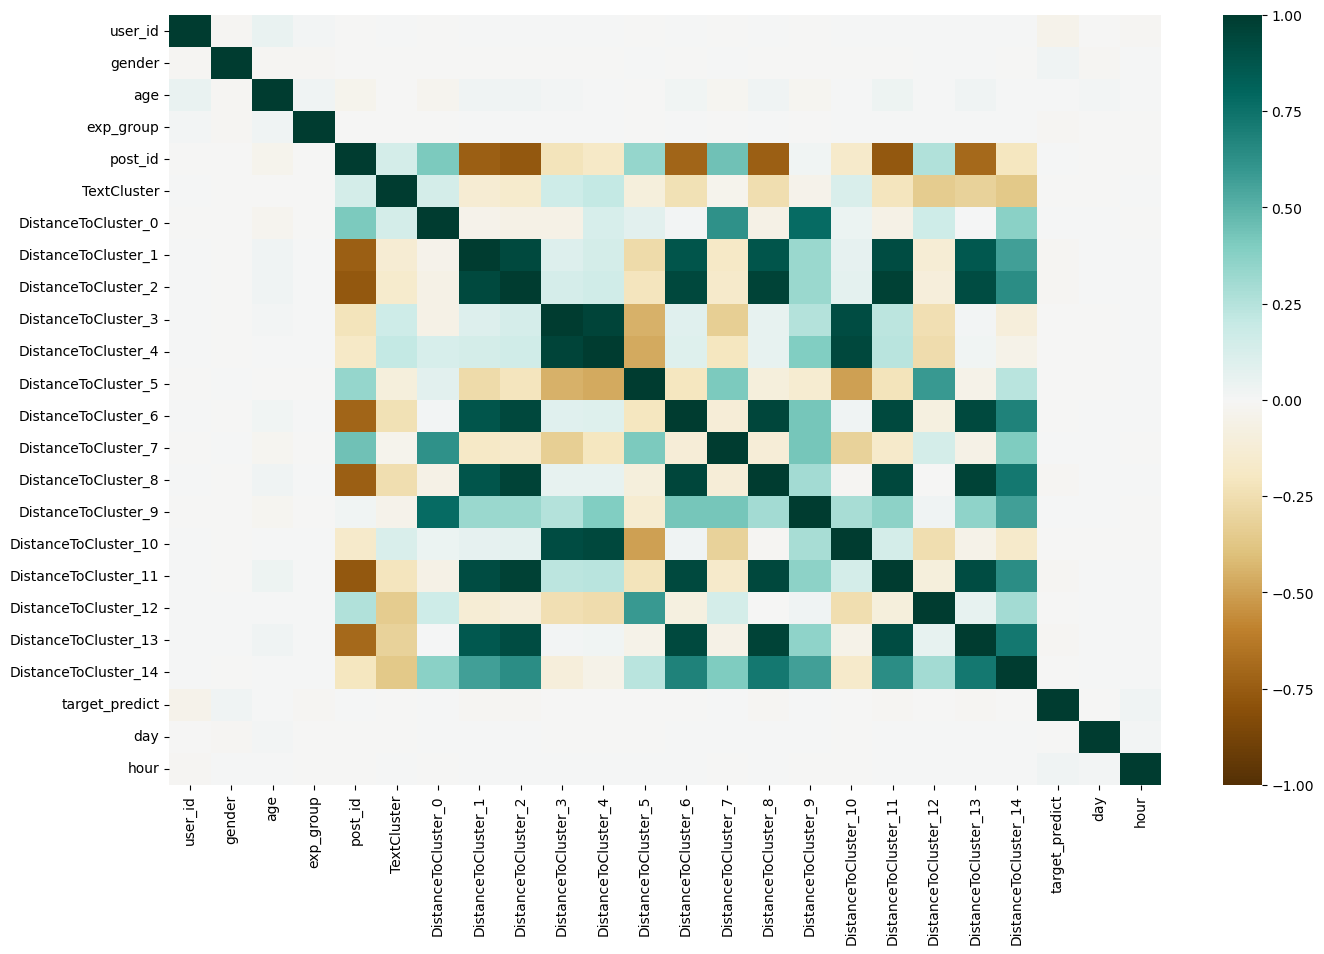

In [44]:
import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[numeric_columns].corr(), 
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()


In [45]:
### Функции для фильтрации признаков

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns], 10))

Top Absolute Correlations
DistanceToCluster_2  DistanceToCluster_11    0.974447
                     DistanceToCluster_8     0.964253
DistanceToCluster_8  DistanceToCluster_13    0.964023
DistanceToCluster_3  DistanceToCluster_4     0.958836
DistanceToCluster_6  DistanceToCluster_8     0.949621
DistanceToCluster_8  DistanceToCluster_11    0.943519
DistanceToCluster_2  DistanceToCluster_6     0.940078
DistanceToCluster_4  DistanceToCluster_10    0.939725
DistanceToCluster_6  DistanceToCluster_13    0.937229
                     DistanceToCluster_11    0.936580
dtype: float64


In [46]:
# посмотрим на категориальные колонки 
categorical_columns = df.loc[:,df.dtypes==object].columns
categorical_columns

Index(['country', 'city', 'os', 'source', 'topic', 'time'], dtype='object')

In [47]:
for col in categorical_columns:
    if col != 'time' : 
        if df[col].nunique() < 5:
            one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

        else:
            mean_target = df.groupby(col)['target_predict'].mean()
            df[col] = df[col].map(mean_target)

In [48]:
df

,user_id,gender,age,country,city,exp_group,post_id,topic,TextCluster,DistanceToCluster_0,...,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time,os_iOS,source_organic
0,200.0,1.0,34.0,0.085868,0.000000,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0
1,201.0,0.0,37.0,0.085868,0.000000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0
2,202.0,1.0,17.0,0.085868,0.142088,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0
3,203.0,0.0,18.0,0.085868,0.116080,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1,0
4,204.0,0.0,36.0,0.085868,0.000000,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,NaN,NaN,NaN,NaN,NaN,NaN,3998.0,0.124767,10.0,3.335328,...,3.550978,3.707293,3.654159,3.599118,0,NaN,NaN,NaN,0,0
662330,NaN,NaN,NaN,NaN,NaN,NaN,4089.0,0.124767,4.0,3.563597,...,3.453243,3.748631,3.733140,3.440623,0,NaN,NaN,NaN,0,0
662331,NaN,NaN,NaN,NaN,NaN,NaN,4099.0,0.124767,4.0,2.861502,...,2.929799,3.334634,3.208457,3.042331,0,NaN,NaN,NaN,0,0
662332,NaN,NaN,NaN,NaN,NaN,NaN,4118.0,0.124767,3.0,3.434369,...,3.034843,3.414204,3.304018,3.369232,0,NaN,NaN,NaN,0,0


In [49]:
for i in df.columns:
    if not i == 'time':
        df[i].fillna(int(df[i].mode()[0]), inplace=True)
df

,user_id,gender,age,country,city,exp_group,post_id,topic,TextCluster,DistanceToCluster_0,...,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time,os_iOS,source_organic
0,200.0,1.0,34.0,0.085868,0.000000,3.0,1468.0,0.000000,11.0,2.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
1,201.0,0.0,37.0,0.085868,0.000000,0.0,1468.0,0.000000,11.0,2.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
2,202.0,1.0,17.0,0.085868,0.142088,4.0,1468.0,0.000000,11.0,2.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
3,203.0,0.0,18.0,0.085868,0.116080,1.0,1468.0,0.000000,11.0,2.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,1,0
4,204.0,0.0,36.0,0.085868,0.000000,3.0,1468.0,0.000000,11.0,2.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,71036.0,1.0,23.0,0.000000,0.000000,1.0,3998.0,0.124767,10.0,3.335328,...,3.550978,3.707293,3.654159,3.599118,0,13.0,19.0,NaN,0,0
662330,71036.0,1.0,23.0,0.000000,0.000000,1.0,4089.0,0.124767,4.0,3.563597,...,3.453243,3.748631,3.733140,3.440623,0,13.0,19.0,NaN,0,0
662331,71036.0,1.0,23.0,0.000000,0.000000,1.0,4099.0,0.124767,4.0,2.861502,...,2.929799,3.334634,3.208457,3.042331,0,13.0,19.0,NaN,0,0
662332,71036.0,1.0,23.0,0.000000,0.000000,1.0,4118.0,0.124767,3.0,3.434369,...,3.034843,3.414204,3.304018,3.369232,0,13.0,19.0,NaN,0,0


# Теперь нарежем этот датафрейм для разных задач

In [50]:
#для обучения модели - удаляем user_id, post_id

In [51]:
df_model = df.drop(['user_id', 'post_id'], axis=1)
df_model

,gender,age,country,city,exp_group,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,...,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time,os_iOS,source_organic
0,1.0,34.0,0.085868,0.000000,3.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
1,0.0,37.0,0.085868,0.000000,0.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
2,1.0,17.0,0.085868,0.142088,4.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
3,0.0,18.0,0.085868,0.116080,1.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,1,0
4,0.0,36.0,0.085868,0.000000,3.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,1.0,23.0,0.000000,0.000000,1.0,0.124767,10.0,3.335328,4.008985,3.676716,...,3.550978,3.707293,3.654159,3.599118,0,13.0,19.0,NaN,0,0
662330,1.0,23.0,0.000000,0.000000,1.0,0.124767,4.0,3.563597,3.060027,3.523236,...,3.453243,3.748631,3.733140,3.440623,0,13.0,19.0,NaN,0,0
662331,1.0,23.0,0.000000,0.000000,1.0,0.124767,4.0,2.861502,3.572364,3.208001,...,2.929799,3.334634,3.208457,3.042331,0,13.0,19.0,NaN,0,0
662332,1.0,23.0,0.000000,0.000000,1.0,0.124767,3.0,3.434369,3.825306,3.419318,...,3.034843,3.414204,3.304018,3.369232,0,13.0,19.0,NaN,0,0


In [52]:
#для записи в таблицу фич пользователей

In [53]:
df.columns

Index(['user_id', 'gender', 'age', 'country', 'city', 'exp_group', 'post_id',
       'topic', 'TextCluster', 'DistanceToCluster_0', 'DistanceToCluster_1',
       'DistanceToCluster_2', 'DistanceToCluster_3', 'DistanceToCluster_4',
       'DistanceToCluster_5', 'DistanceToCluster_6', 'DistanceToCluster_7',
       'DistanceToCluster_8', 'DistanceToCluster_9', 'DistanceToCluster_10',
       'DistanceToCluster_11', 'DistanceToCluster_12', 'DistanceToCluster_13',
       'DistanceToCluster_14', 'target_predict', 'day', 'hour', 'time',
       'os_iOS', 'source_organic'],
      dtype='object')

In [54]:
df_users = df[['user_id', 'gender', 'age', 'country', 'city', 'exp_group','os_iOS',
       'source_organic']]
df_users.drop_duplicates(inplace = True)
df_users.reset_index(drop=True, inplace = True)
df_users

,user_id,gender,age,country,city,exp_group,os_iOS,source_organic
0,200.0,1.0,34.0,0.085868,0.000000,3.0,0,0
1,201.0,0.0,37.0,0.085868,0.000000,0.0,0,0
2,202.0,1.0,17.0,0.085868,0.142088,4.0,0,0
3,203.0,0.0,18.0,0.085868,0.116080,1.0,1,0
4,204.0,0.0,36.0,0.085868,0.000000,3.0,0,0
...,...,...,...,...,...,...,...,...
163201,84867.0,1.0,41.0,0.085868,0.120292,0.0,0,0
163202,12757.0,1.0,38.0,0.085868,0.083015,3.0,1,0
163203,39725.0,1.0,19.0,0.085868,0.116080,4.0,1,0
163204,71125.0,1.0,25.0,0.085868,0.101304,3.0,0,0


In [55]:
#для записи в таблицу фич постов

In [56]:
df_posts = df[['post_id','topic','TextCluster',
       'DistanceToCluster_0', 'DistanceToCluster_1', 'DistanceToCluster_2',
       'DistanceToCluster_3', 'DistanceToCluster_4', 'DistanceToCluster_5',
       'DistanceToCluster_6', 'DistanceToCluster_7', 'DistanceToCluster_8',
       'DistanceToCluster_9', 'DistanceToCluster_10', 'DistanceToCluster_11',
       'DistanceToCluster_12', 'DistanceToCluster_13', 'DistanceToCluster_14']] #'text'
df_posts.drop_duplicates(inplace = True)
df_posts.reset_index(drop=True, inplace = True)
df_posts

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14
0,1468.0,0.000000,11.0,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000
1,5515.0,0.127569,11.0,3.215524,2.806880,2.040743,2.528912,2.599734,3.438293,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354
2,1690.0,0.125319,5.0,3.132009,3.560590,3.235123,3.692743,3.494324,1.464922,3.356014,3.028158,3.142819,3.206445,3.835396,3.093872,2.746949,3.064192,2.744170
3,1434.0,0.125319,5.0,3.348638,3.861527,3.552094,3.875918,3.664286,1.626423,3.738747,3.176795,3.471849,3.447753,4.028896,3.554562,3.105580,3.509705,3.073877
4,5104.0,0.127569,2.0,3.183518,2.388330,1.468479,3.384365,3.071504,3.780993,2.192455,3.533173,1.945416,2.825851,3.436491,1.975136,3.649418,2.211713,2.623475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,3998.0,0.124767,10.0,3.335328,4.008985,3.676716,2.732740,2.694882,4.107583,3.753114,3.838913,3.652239,3.382991,2.365867,3.550978,3.707293,3.654159,3.599118
7020,4089.0,0.124767,4.0,3.563597,3.060027,3.523236,2.965754,2.817045,4.202417,3.673074,3.993683,3.635429,3.560068,2.934697,3.453243,3.748631,3.733140,3.440623
7021,4099.0,0.124767,4.0,2.861502,3.572364,3.208001,1.760491,1.658007,3.541975,3.382361,3.170268,3.209351,2.641374,1.987588,2.929799,3.334634,3.208457,3.042331
7022,4118.0,0.124767,3.0,3.434369,3.825306,3.419318,2.518435,2.698241,3.739968,3.592566,3.910847,3.316971,3.391457,2.923803,3.034843,3.414204,3.304018,3.369232


In [57]:
#для анализа корреляций и прочего

In [58]:
df_1 = df_model.drop(['time'], axis=1)
df_1

,gender,age,country,city,exp_group,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,...,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,os_iOS,source_organic
0,1.0,34.0,0.085868,0.000000,3.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,0,0
1,0.0,37.0,0.085868,0.000000,0.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,0,0
2,1.0,17.0,0.085868,0.142088,4.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,0,0
3,0.0,18.0,0.085868,0.116080,1.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,1,0
4,0.0,36.0,0.085868,0.000000,3.0,0.000000,11.0,2.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0,13.0,19.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662329,1.0,23.0,0.000000,0.000000,1.0,0.124767,10.0,3.335328,4.008985,3.676716,...,2.365867,3.550978,3.707293,3.654159,3.599118,0,13.0,19.0,0,0
662330,1.0,23.0,0.000000,0.000000,1.0,0.124767,4.0,3.563597,3.060027,3.523236,...,2.934697,3.453243,3.748631,3.733140,3.440623,0,13.0,19.0,0,0
662331,1.0,23.0,0.000000,0.000000,1.0,0.124767,4.0,2.861502,3.572364,3.208001,...,1.987588,2.929799,3.334634,3.208457,3.042331,0,13.0,19.0,0,0
662332,1.0,23.0,0.000000,0.000000,1.0,0.124767,3.0,3.434369,3.825306,3.419318,...,2.923803,3.034843,3.414204,3.304018,3.369232,0,13.0,19.0,0,0


In [59]:
df_1.corr()

,gender,age,country,city,exp_group,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,...,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,os_iOS,source_organic
gender,1.000000,-0.012544,0.039420,0.084687,-0.009390,-0.000521,-0.000551,-0.001542,-0.000678,-0.000135,...,-0.002454,0.000248,0.002240,0.000933,-0.000582,0.027818,-0.012876,0.003502,-0.013346,0.003108
age,-0.012544,1.000000,0.000622,0.000897,0.024757,0.008353,-0.008660,-0.004727,0.022353,0.023275,...,0.004232,0.024662,0.008410,0.020395,0.009950,0.002442,0.008637,-0.001726,-0.008293,0.042754
country,0.039420,0.000622,1.000000,0.362831,-0.021555,0.017273,-0.009627,0.015629,0.003076,-0.002444,...,0.005181,-0.003417,0.005071,-0.003213,0.013310,0.060847,0.004174,-0.014636,0.032825,-0.026316
city,0.084687,0.000897,0.362831,1.000000,-0.042408,0.311235,-0.145312,0.246934,0.065998,-0.032633,...,0.053917,-0.053204,0.099085,-0.042353,0.222162,0.167501,0.040500,-0.135839,0.032407,-0.106752
exp_group,-0.009390,0.024757,-0.021555,-0.042408,1.000000,0.007510,-0.003641,0.004544,0.005716,0.003680,...,0.002409,0.003180,0.002907,0.002992,0.006563,-0.010652,-0.000826,-0.005140,0.019077,0.004845
topic,-0.000521,0.008353,0.017273,0.311235,0.007510,1.000000,-0.457889,0.801795,0.186333,-0.131873,...,0.164117,-0.195934,0.316305,-0.158725,0.703006,0.191472,0.143806,-0.421587,-0.004256,-0.287047
TextCluster,-0.000551,-0.008660,-0.009627,-0.145312,-0.003641,-0.457889,1.000000,-0.283460,-0.220685,-0.094216,...,0.027431,-0.112373,-0.443124,-0.213898,-0.553518,-0.089141,-0.067665,0.196849,0.004591,0.133316
DistanceToCluster_0,-0.001542,-0.004727,0.015629,0.246934,0.004544,0.801795,-0.283460,1.000000,0.144195,-0.116072,...,0.160984,-0.165203,0.351590,-0.098573,0.719366,0.152089,0.114400,-0.332932,-0.001659,-0.225618
DistanceToCluster_1,-0.000678,0.022353,0.003076,0.065998,0.005716,0.186333,-0.220685,0.144195,1.000000,0.883429,...,0.103013,0.844811,-0.051520,0.807943,0.542893,0.032913,0.033757,-0.089249,-0.006100,-0.059762
DistanceToCluster_2,-0.000135,0.023275,-0.002444,-0.032633,0.003680,-0.131873,-0.094216,-0.116072,0.883429,1.000000,...,0.055318,0.972721,-0.134426,0.921411,0.377289,-0.029182,-0.012309,0.045140,-0.004941,0.031027


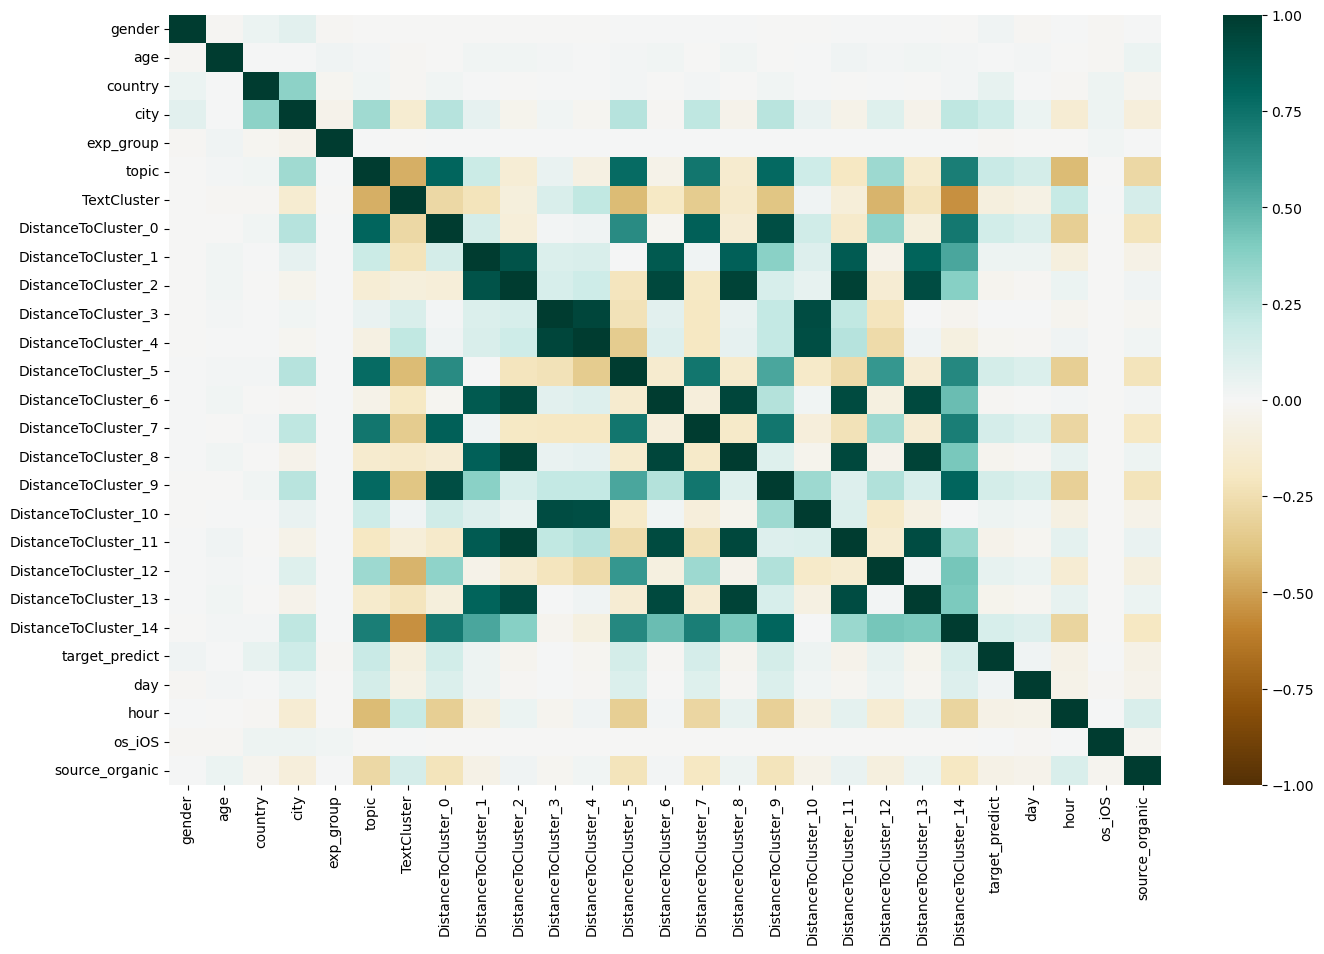

In [60]:
import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df_1.corr(), 
            xticklabels=df_1.columns,
            yticklabels=df_1.columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

In [61]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_1, 10))

Top Absolute Correlations
DistanceToCluster_2  DistanceToCluster_11    0.972721
DistanceToCluster_8  DistanceToCluster_13    0.964574
DistanceToCluster_2  DistanceToCluster_8     0.964416
DistanceToCluster_3  DistanceToCluster_4     0.950833
DistanceToCluster_6  DistanceToCluster_8     0.945510
DistanceToCluster_8  DistanceToCluster_11    0.943822
DistanceToCluster_2  DistanceToCluster_6     0.937872
DistanceToCluster_6  DistanceToCluster_13    0.932454
                     DistanceToCluster_11    0.928037
DistanceToCluster_2  DistanceToCluster_13    0.921411
dtype: float64


In [62]:
df_model[df_model['time'].notna() == True].sort_values('time')

,gender,age,country,city,exp_group,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,...,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,target_predict,day,hour,time,os_iOS,source_organic
180752,1.0,17.0,0.085868,0.135311,1.0,0.127569,11.0,3.429197,2.761199,1.902186,...,1.620047,3.604599,2.198325,2.597407,0,1.0,18.0,2021-10-01,1,0
297129,1.0,18.0,0.085868,0.059471,0.0,0.128118,14.0,2.786329,3.107544,2.819900,...,2.524571,3.063700,2.491032,2.107741,0,1.0,15.0,2021-10-01,0,1
252273,1.0,26.0,0.085868,0.134978,0.0,0.125319,5.0,4.168410,4.689189,4.450360,...,4.378953,3.493508,4.105238,3.771057,0,1.0,17.0,2021-10-01,1,0
540570,0.0,41.0,0.085868,0.116080,4.0,0.128118,14.0,2.909847,3.287819,2.843324,...,2.642557,3.075857,2.583240,1.818463,0,1.0,20.0,2021-10-01,0,0
485812,1.0,22.0,0.085868,0.065546,1.0,0.125319,5.0,3.725345,4.328613,4.105176,...,4.009736,3.101735,3.678616,3.367545,0,1.0,11.0,2021-10-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586194,0.0,36.0,0.085868,0.039695,3.0,0.127569,8.0,3.461419,2.846035,1.809295,...,2.381037,3.507687,2.199585,2.623446,0,29.0,20.0,2021-12-29,1,0
280579,1.0,31.0,0.085868,0.079313,4.0,0.124767,10.0,3.044135,3.524212,3.088397,...,3.003099,3.548724,3.294010,3.343021,0,29.0,19.0,2021-12-29,1,1
497072,0.0,33.0,0.085868,0.023064,3.0,0.124767,4.0,3.109258,3.192890,2.688858,...,2.480819,3.436891,3.014868,2.903810,0,29.0,17.0,2021-12-29,0,1
426182,1.0,21.0,0.085868,0.131562,4.0,0.127569,13.0,2.888901,2.594860,2.800374,...,2.701155,3.091999,2.267030,2.844660,0,29.0,14.0,2021-12-29,0,0


In [63]:
X = df_model.drop('target_predict', axis=1)
y = df_model['target_predict']

### Будем считать MSLE

### Отделим валидацию от теста по времени!

X_test, X_train = X[X.time >= dt.date.fromisoformat('2021-10-01')], X[X.time < dt.date.fromisoformat('2021-11-29')]

y_test, y_train = y[y.index.isin(X_test.index)], y[y.index.isin(X_train.index)]

### Уберем колонку с датой


X_test = X_test.drop('time', axis=1)
X_train = X_train.drop('time', axis=1)
X = X.drop('time', axis=1)


X.columns

Index(['gender', 'age', 'country', 'city', 'exp_group', 'topic', 'TextCluster',
       'DistanceToCluster_0', 'DistanceToCluster_1', 'DistanceToCluster_2',
       'DistanceToCluster_3', 'DistanceToCluster_4', 'DistanceToCluster_5',
       'DistanceToCluster_6', 'DistanceToCluster_7', 'DistanceToCluster_8',
       'DistanceToCluster_9', 'DistanceToCluster_10', 'DistanceToCluster_11',
       'DistanceToCluster_12', 'DistanceToCluster_13', 'DistanceToCluster_14',
       'day', 'hour', 'os_iOS', 'source_organic'],
      dtype='object')

In [64]:
# !pip install lightgbm==3.3.5

In [79]:
import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(n_jobs = 16, n_estimators = 130, num_leaves = 1000)

lgbm_model.fit(X_train, y_train)

lgbm_model.score(X_test, y_test)

0.9112845720365788

In [80]:
df_users

,user_id,gender,age,country,city,exp_group,os_iOS,source_organic
0,200.0,1.0,34.0,0.085868,0.000000,3.0,0,0
1,201.0,0.0,37.0,0.085868,0.000000,0.0,0,0
2,202.0,1.0,17.0,0.085868,0.142088,4.0,0,0
3,203.0,0.0,18.0,0.085868,0.116080,1.0,1,0
4,204.0,0.0,36.0,0.085868,0.000000,3.0,0,0
...,...,...,...,...,...,...,...,...
163201,84867.0,1.0,41.0,0.085868,0.120292,0.0,0,0
163202,12757.0,1.0,38.0,0.085868,0.083015,3.0,1,0
163203,39725.0,1.0,19.0,0.085868,0.116080,4.0,1,0
163204,71125.0,1.0,25.0,0.085868,0.101304,3.0,0,0


In [81]:
df_posts

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14
0,1468.0,0.000000,11.0,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000
1,5515.0,0.127569,11.0,3.215524,2.806880,2.040743,2.528912,2.599734,3.438293,2.386057,3.352056,2.030947,2.772673,3.049264,1.632080,3.326175,2.046280,2.571354
2,1690.0,0.125319,5.0,3.132009,3.560590,3.235123,3.692743,3.494324,1.464922,3.356014,3.028158,3.142819,3.206445,3.835396,3.093872,2.746949,3.064192,2.744170
3,1434.0,0.125319,5.0,3.348638,3.861527,3.552094,3.875918,3.664286,1.626423,3.738747,3.176795,3.471849,3.447753,4.028896,3.554562,3.105580,3.509705,3.073877
4,5104.0,0.127569,2.0,3.183518,2.388330,1.468479,3.384365,3.071504,3.780993,2.192455,3.533173,1.945416,2.825851,3.436491,1.975136,3.649418,2.211713,2.623475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,3998.0,0.124767,10.0,3.335328,4.008985,3.676716,2.732740,2.694882,4.107583,3.753114,3.838913,3.652239,3.382991,2.365867,3.550978,3.707293,3.654159,3.599118
7020,4089.0,0.124767,4.0,3.563597,3.060027,3.523236,2.965754,2.817045,4.202417,3.673074,3.993683,3.635429,3.560068,2.934697,3.453243,3.748631,3.733140,3.440623
7021,4099.0,0.124767,4.0,2.861502,3.572364,3.208001,1.760491,1.658007,3.541975,3.382361,3.170268,3.209351,2.641374,1.987588,2.929799,3.334634,3.208457,3.042331
7022,4118.0,0.124767,3.0,3.434369,3.825306,3.419318,2.518435,2.698241,3.739968,3.592566,3.910847,3.316971,3.391457,2.923803,3.034843,3.414204,3.304018,3.369232


In [82]:
user_test = df_users[df_users['user_id'] == 70224].iloc[0] # нужна именно серия

df_test = df_posts.merge(pd.DataFrame(data=[user_test.values] * len(df_posts), columns=user_test.index),
                              left_index=True, right_index=True)

df_test

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,...,DistanceToCluster_13,DistanceToCluster_14,user_id,gender,age,country,city,exp_group,os_iOS,source_organic
0,1468.0,0.000000,11.0,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,...,3.000000,2.000000,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
1,5515.0,0.127569,11.0,3.215524,2.806880,2.040743,2.528912,2.599734,3.438293,2.386057,...,2.046280,2.571354,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
2,1690.0,0.125319,5.0,3.132009,3.560590,3.235123,3.692743,3.494324,1.464922,3.356014,...,3.064192,2.744170,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
3,1434.0,0.125319,5.0,3.348638,3.861527,3.552094,3.875918,3.664286,1.626423,3.738747,...,3.509705,3.073877,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
4,5104.0,0.127569,2.0,3.183518,2.388330,1.468479,3.384365,3.071504,3.780993,2.192455,...,2.211713,2.623475,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,3998.0,0.124767,10.0,3.335328,4.008985,3.676716,2.732740,2.694882,4.107583,3.753114,...,3.654159,3.599118,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
7020,4089.0,0.124767,4.0,3.563597,3.060027,3.523236,2.965754,2.817045,4.202417,3.673074,...,3.733140,3.440623,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
7021,4099.0,0.124767,4.0,2.861502,3.572364,3.208001,1.760491,1.658007,3.541975,3.382361,...,3.208457,3.042331,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0
7022,4118.0,0.124767,3.0,3.434369,3.825306,3.419318,2.518435,2.698241,3.739968,3.592566,...,3.304018,3.369232,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0


In [83]:
# также добавляем время

In [84]:
date_time = dt.datetime(year=2021, month=1, day=3, hour=14)

df_dt = pd.DataFrame({'day':[date_time.day],
                      'hour': [date_time.hour]
                     }).iloc[0]

df_test = df_test.merge(pd.DataFrame(data=[df_dt.values] * len(df_test), columns=df_dt.index),
                              left_index=True, right_index=True)

df_test

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,...,user_id,gender,age,country,city,exp_group,os_iOS,source_organic,day,hour
0,1468.0,0.000000,11.0,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
1,5515.0,0.127569,11.0,3.215524,2.806880,2.040743,2.528912,2.599734,3.438293,2.386057,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
2,1690.0,0.125319,5.0,3.132009,3.560590,3.235123,3.692743,3.494324,1.464922,3.356014,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
3,1434.0,0.125319,5.0,3.348638,3.861527,3.552094,3.875918,3.664286,1.626423,3.738747,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
4,5104.0,0.127569,2.0,3.183518,2.388330,1.468479,3.384365,3.071504,3.780993,2.192455,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,3998.0,0.124767,10.0,3.335328,4.008985,3.676716,2.732740,2.694882,4.107583,3.753114,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
7020,4089.0,0.124767,4.0,3.563597,3.060027,3.523236,2.965754,2.817045,4.202417,3.673074,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
7021,4099.0,0.124767,4.0,2.861502,3.572364,3.208001,1.760491,1.658007,3.541975,3.382361,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14
7022,4118.0,0.124767,3.0,3.434369,3.825306,3.419318,2.518435,2.698241,3.739968,3.592566,...,70224.0,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14


In [85]:
# поменятем порядок колонок на тот, который был при обучении модели

In [86]:
g = lgbm_model.predict_proba(df_test[['gender', 'age', 'country', 'city', 'exp_group', 'topic', 'TextCluster',
       'DistanceToCluster_0', 'DistanceToCluster_1', 'DistanceToCluster_2',
       'DistanceToCluster_3', 'DistanceToCluster_4', 'DistanceToCluster_5',
       'DistanceToCluster_6', 'DistanceToCluster_7', 'DistanceToCluster_8',
       'DistanceToCluster_9', 'DistanceToCluster_10', 'DistanceToCluster_11',
       'DistanceToCluster_12', 'DistanceToCluster_13', 'DistanceToCluster_14',
       'day', 'hour', 'os_iOS', 'source_organic']]
                       )[:, 1]
#g = pd.DataFrame(g)
g

array([0.01666056, 0.02839352, 0.01120756, ..., 0.03247546, 0.01636099,
       0.10706013])

In [87]:
df_test['proba'] = g
df_test

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,...,gender,age,country,city,exp_group,os_iOS,source_organic,day,hour,proba
0,1468.0,0.000000,11.0,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.016661
1,5515.0,0.127569,11.0,3.215524,2.806880,2.040743,2.528912,2.599734,3.438293,2.386057,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.028394
2,1690.0,0.125319,5.0,3.132009,3.560590,3.235123,3.692743,3.494324,1.464922,3.356014,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.011208
3,1434.0,0.125319,5.0,3.348638,3.861527,3.552094,3.875918,3.664286,1.626423,3.738747,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.017186
4,5104.0,0.127569,2.0,3.183518,2.388330,1.468479,3.384365,3.071504,3.780993,2.192455,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.151734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,3998.0,0.124767,10.0,3.335328,4.008985,3.676716,2.732740,2.694882,4.107583,3.753114,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.044676
7020,4089.0,0.124767,4.0,3.563597,3.060027,3.523236,2.965754,2.817045,4.202417,3.673074,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.058816
7021,4099.0,0.124767,4.0,2.861502,3.572364,3.208001,1.760491,1.658007,3.541975,3.382361,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.032475
7022,4118.0,0.124767,3.0,3.434369,3.825306,3.419318,2.518435,2.698241,3.739968,3.592566,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.016361


In [88]:
t = df_test.sort_values('proba', ascending=False)
t

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,...,gender,age,country,city,exp_group,os_iOS,source_organic,day,hour,proba
6642,6995.0,0.127569,11.0,3.158453,2.580255,1.892505,2.976188,2.810948,3.412204,2.267995,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.566448
4109,6179.0,0.127569,8.0,3.100440,2.475939,1.899374,3.191493,3.047872,3.344545,2.339135,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.506594
5813,4978.0,0.127569,2.0,3.096914,2.529906,1.563275,3.138960,2.835588,3.738634,2.163702,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.437435
4582,7009.0,0.127569,8.0,3.032964,2.898403,2.097716,3.142233,3.080360,3.149859,2.179010,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.415364
4519,630.0,0.128118,14.0,2.415240,2.816100,2.280960,3.190073,2.845821,3.118588,2.625656,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.410414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3725,1187.0,0.116058,7.0,2.548263,3.149141,3.025460,3.268124,2.948184,2.898620,2.978631,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.004754
2721,1611.0,0.125319,5.0,3.426602,3.883195,3.546614,3.779971,3.704972,1.809536,3.459432,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.004529
5198,1629.0,0.125319,5.0,3.522607,4.025847,3.916635,4.083614,4.044168,2.382204,3.791511,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.004302
2516,1662.0,0.125319,5.0,3.522606,4.025846,3.916634,4.083613,4.044167,2.382204,3.791510,...,1.0,36.0,0.085868,0.038591,2.0,0.0,0.0,3,14,0.004302


In [89]:
posts_list = []


for i in t['post_id']:
    if len(posts_list) < 5:
        posts_list.append(int(i))
        
posts_list

[6995, 6179, 4978, 7009, 630]

## Заливаем данные на сервер и проверяем, что всё работает

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)


df_users.to_sql('v-susanin_features_lesson_22', con=engine, if_exists = 'replace',  index=False) # записываем таблицу

In [ ]:
df_users = pd.read_sql('SELECT * FROM "v-susanin_features_lesson_22"', con=engine) # считываем таблицу(проверяем, что залили)
df_users

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)


df_posts.to_sql('v-susanin_posts_features_lesson_22', con=engine, if_exists = 'replace',  index=False) # записываем таблицу

In [ ]:
df_posts = pd.read_sql('SELECT * FROM "v-susanin_posts_features_lesson_22"', con=engine) 
# считываем таблицу(проверяем, что залили)
df_posts

In [ ]:
def posts_rec(id, time, limit):
    
    # добавляем к фичам юзера список постов с их фичами
    user_test = df_users[df_users['user_id'] == id].iloc[0] # нужна именно серия
    
    df_test = df_posts.merge(pd.DataFrame(data=[user_test.values] * len(df_posts), columns=user_test.index),
                              left_index=True, right_index=True)
    
    # также добавляем время
    date_time = time
    
    df_dt = pd.DataFrame({'day':[date_time.day],
                      'hour': [date_time.hour]
                     }).iloc[0]
    
    df_test = df_test.merge(pd.DataFrame(data=[df_dt.values] * len(df_test), columns=df_dt.index),
                              left_index=True, right_index=True)

    # поменяем порядок колонок на тот, который был при обучении модели и проведём расчёт
    df_test['proba'] = lgbm_model.predict_proba(df_test[['gender', 'age', 'country', 'city', 'exp_group', 'topic', 'TextCluster',
       'DistanceToCluster_0', 'DistanceToCluster_1', 'DistanceToCluster_2',
       'DistanceToCluster_3', 'DistanceToCluster_4', 'DistanceToCluster_5',
       'DistanceToCluster_6', 'DistanceToCluster_7', 'DistanceToCluster_8',
       'DistanceToCluster_9', 'DistanceToCluster_10', 'DistanceToCluster_11',
       'DistanceToCluster_12', 'DistanceToCluster_13', 'DistanceToCluster_14',
       'day', 'hour', 'os_iOS', 'source_organic']])[:, 1]

    t = df_test.sort_values('proba', ascending=False)

    posts_list = []

    for i in t['post_id']:
        if len(posts_list) < limit:
            posts_list.append(int(i))
            posts_list
        #print(posts_list)
    result = posts.loc[posts['id'].isin(posts_list)].to_dict('records')
    return result

In [ ]:
posts = pd.read_sql(
    """SELECT * FROM public.post_text_df """,
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)
posts.rename(columns = {'post_id':'id'}, inplace = True )

In [ ]:
posts_rec(70224, date_time, 5)

## Сохраняем модель

In [90]:
import pickle

filename = 'lgbm_model.pkl'

pickle.dump(lgbm_model, open(filename, 'wb'))

In [91]:
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.predict_proba(X_train)[:,1]

array([0.01771304, 0.06660284, 0.02544465, ..., 0.13274256, 0.08243849,
       0.19213091])